In [12]:
import pandas as pd
import scipy.sparse
import scipy
import scipy.io
import numpy as np
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.manifold import TSNE
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()

## Import clean train data 

In [13]:
train_clean = pd.read_csv('Data/train_clean.tsv', sep='\t', header=0)

#splitting train_clean into train_base and test_base as our test.tsv has no price labels for us to check against
train_base = train_clean.iloc[:1000000,:]
test_base = train_clean.iloc[1000000:,:]

In [14]:
#Baseline Prediction: get the mean values per category_name_1
mean_values = train_base.groupby('category_name_1')['price'].mean()
df_means = pd.DataFrame(mean_values)
df_means.reset_index(inplace=True)
df_means.rename(columns={'price':'prediction'}, inplace=True)



In [15]:
#testFile = pd.read_csv('Data/test.tsv', sep='\t', header=0)

#split by category_name
#df.join(df['AB'].str.split('-', 1, expand=True).rename(columns={0:'A', 1:'B'}))
#testFile['category_name'].str.split('/',2, expand=True).rename(columns={0:'category_1', 1:'category_2', 2:'category_3'})

## Import sparse matrix 

In [16]:
#import train_term_matrix
train_sparse = scipy.io.mmread('Data/train_term_matrix_pruned.mtx')
y = train_clean['price']

In [17]:
# Sample Data to reduce the size
numSamples = 100000
train_sparse_sample, y_sample = resample(train_sparse, y, 
                               n_samples=numSamples,
                               random_state=777)

In [18]:
print('sparse shape', y_sample.shape)

sparse shape (100000,)


In [19]:
from sklearn.model_selection import train_test_split


XTrain, XTest, yTrain, yTest = train_test_split(train_sparse_sample, y_sample,
                                                test_size=0.33, random_state=95828)

## Baseline Model - Use average of category_name_1 products

In [20]:
from sklearn.metrics import mean_squared_error

#merge with df_means to get mean 'prediction'
test_base_pred = test_base.merge(df_means, how='left', on='category_name_1')

#remove rows with NaN in category_1
test_base_pred = test_base_pred[test_base_pred.category_name_1.notnull()]

mse_base = mean_squared_error(test_base_pred['price'], test_base_pred['prediction'])
print('Baseline model MSE = {:.2f}'.format(mse_base))


Baseline model MSE = 1450.86


## Random Forest Regression

In [21]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

model_mse = []

rf = RandomForestRegressor(random_state=0)
pred_rf = rf.fit(XTrain, yTrain).predict(XTest)

mse_rf = mean_squared_error(yTest, pred_rf)
print('RandomForest Regressor: MSE = {:.2f}'.format(mse_rf))
model_mse.append(['RandomForest', round(mse_rf,2)])

#add GridSearch later
# params_maxDepth = {'max_depth':[2,5,10,15,20]}
# clf = GridSearchCV(treeReg, params_maxDepth)
# clf.fit(XTrain, yTrain)

RandomForest Regressor: MSE = 1388.74
CPU times: user 5min 25s, sys: 579 ms, total: 5min 25s
Wall time: 5min 26s


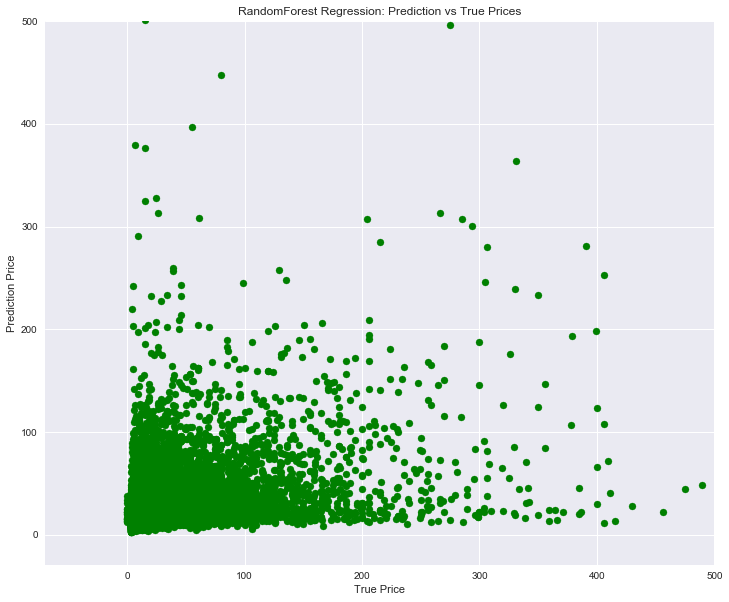

In [52]:
plt.figure(figsize=(12,10))
plt.scatter(yTest, pred_rf, c="g")
plt.ylabel("Prediction Price")
plt.ylim(ymax = 500)
plt.xlim(xmax = 500)
plt.xlabel("True Price")
plt.title("RandomForest Regression: Prediction vs True Prices");
#plt.savefig('rf.png')

## AdaBoost Regression

In [23]:
%%time
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(DecisionTreeRegressor(), random_state=100)
pred_ada = ada.fit(XTrain, yTrain).predict(XTest)

mse_ada = mean_squared_error(yTest, pred_ada)
print('AdaBoost Regresion: MSE = {:.2f}'.format(mse_ada))
model_mse.append(['AdaBoost', round(mse_ada,2)])

AdaBoost Regresion: MSE = 22075.29
CPU times: user 2min 51s, sys: 179 ms, total: 2min 51s
Wall time: 2min 51s


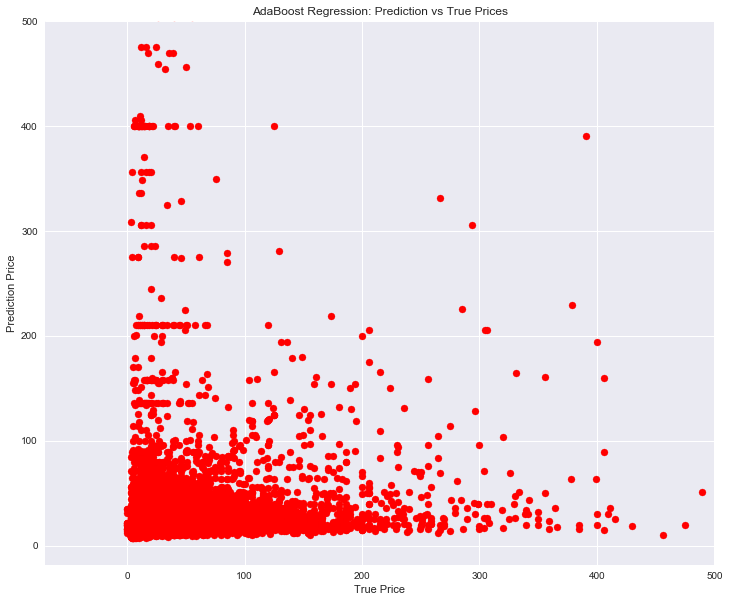

In [51]:
plt.figure(figsize=(12,10))
plt.scatter(yTest, pred_ada, c="r")
plt.ylabel("Prediction Price")
plt.ylim(ymax = 500)
plt.xlim(xmax = 500)
plt.xlabel("True Price")
plt.title("AdaBoost Regression: Prediction vs True Prices");
#plt.savefig('ada.png')

## Ridge Regression

In [25]:
%%time
from sklearn.linear_model import Ridge

#add in gridsearch later
ridge = Ridge(alpha=1.0)
pred_ridge = ridge.fit(XTrain, yTrain).predict(XTest)

mse_ridge = mean_squared_error(yTest, pred_ridge)
print('Ridge Regression: MSE = {:.2f}'.format(mse_ridge))
model_mse.append(['Ridge', round(mse_ridge,2)])

Ridge Regression: MSE = 1356.94
CPU times: user 1.51 s, sys: 10.3 ms, total: 1.52 s
Wall time: 1.52 s


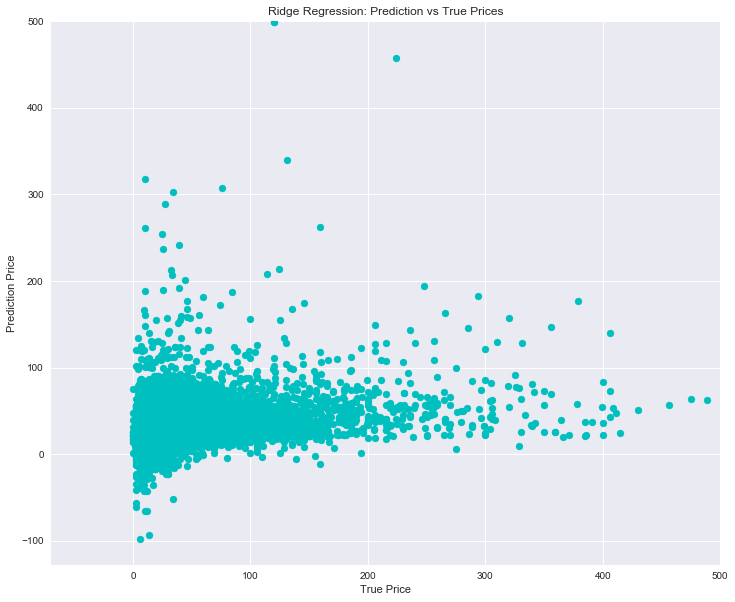

In [50]:
plt.figure(figsize=(12,10))
plt.scatter(yTest, pred_ridge, c="c")
plt.ylabel("Prediction Price")
plt.ylim(ymax = 500)
plt.xlim(xmax = 500)
plt.xlabel("True Price")
plt.title("Ridge Regression: Prediction vs True Prices");
#plt.savefig('ridge.png')

## Lasso Regression

In [27]:
%%time
from sklearn.linear_model import Lasso

#add in gridsearch later
lasso = Lasso(alpha=1.0)
pred_lasso = lasso.fit(XTrain, yTrain).predict(XTest)

mse_lasso = mean_squared_error(yTest, pred_lasso)
print('Lasso Regression: MSE = {:.2f}'.format(mse_lasso))
model_mse.append(['Lasso', round(mse_lasso,2)])

Lasso Regression: MSE = 1486.35
CPU times: user 185 ms, sys: 4.12 ms, total: 189 ms
Wall time: 190 ms


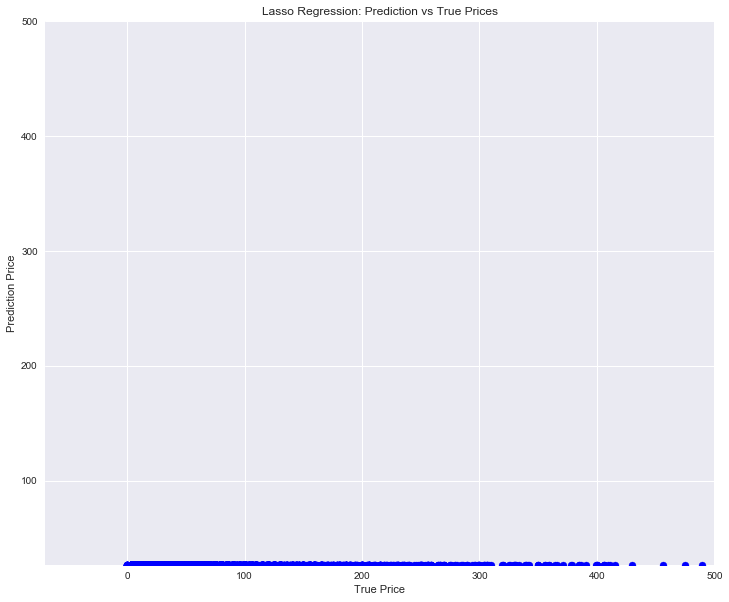

In [49]:
plt.figure(figsize=(12,10))
plt.scatter(yTest, pred_lasso, c="b")
plt.ylabel("Prediction Price")
plt.ylim(ymax = 500)
plt.xlim(xmax = 500)
plt.xlabel("True Price")
plt.title("Lasso Regression: Prediction vs True Prices");
#plt.savefig('lasso.png')

## KNeighbors Regression

In [29]:
from sklearn.neighbors import KNeighborsRegressor

#add grid search on hyperparams later
knn = KNeighborsRegressor(n_neighbors=5)
pred_knn = knn.fit(XTrain, yTrain).predict(XTest)

mse_knn = mean_squared_error(yTest, pred_knn)
print('KNeighbors Regression: MSE = {:.2f}'.format(mse_knn))
model_mse.append(['KNeighborsRegressor', round(mse_knn,2)])


KNeighbors Regression: MSE = 1553.31


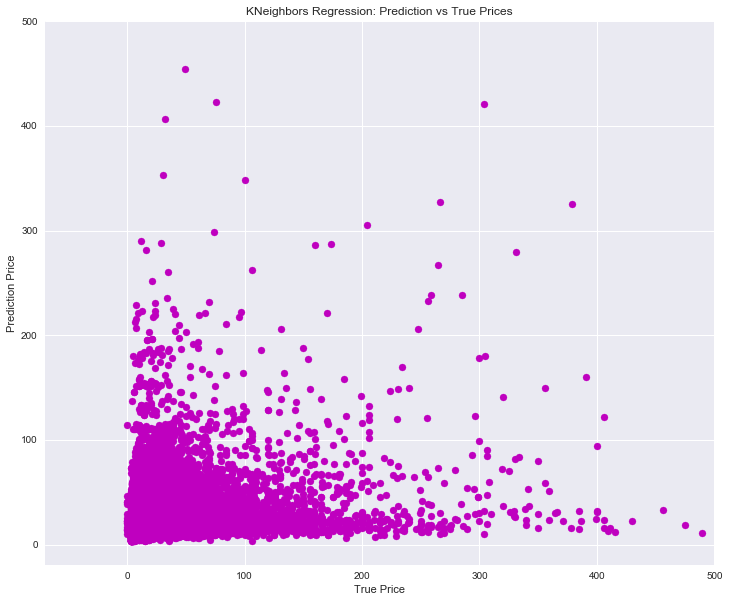

In [48]:
plt.figure(figsize=(12,10))
plt.scatter(yTest, pred_knn, c="m")
plt.ylabel("Prediction Price")
plt.ylim(ymax = 500)
plt.xlim(xmax = 500)
plt.xlabel("True Price")
plt.title("KNeighbors Regression: Prediction vs True Prices");
#plt.savefig('knn.png')

In [45]:
print("Regression Model MSE")
for reg, mse in model_mse:
    print("{:<19}: {:>8.2f}".format(reg,mse))
          

Regression Model MSE
RandomForest       :  1388.74
AdaBoost           : 22075.29
Ridge              :  1356.94
Lasso              :  1486.35
KNeighborsRegressor:  1553.31


In [53]:
#convert to np array to plot
np_model_mse = np.array(model_mse)
regrs = np_model_mse[:,0]
mses = np_model_mse[:,1]

## Bar chart of the diffierent models MSE

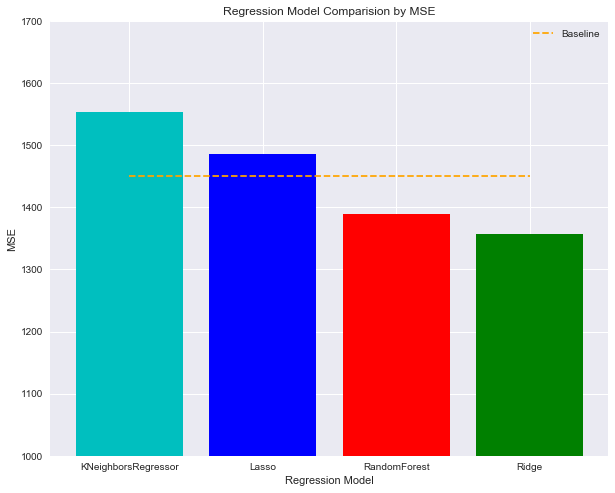

In [99]:

plt.figure(figsize=(10,8))
plt.bar(['RandomForest','Ridge','Lasso','KNeighborsRegressor'],[1388.74,1356.94,1486.35,1553.31],
       color=['red', 'green', 'blue', 'c'])
plt.plot([0,3],[mse_base,mse_base],'k--',c='orange',label="Baseline")
plt.xlabel("Regression Model")
plt.ylim(ymax = 1700, ymin=1000)
plt.ylabel("MSE")
plt.title("Regression Model Comparision by MSE");
plt.legend()
#plt.savefig('mse.png')